In [13]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values

        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
            X = np.concatenate((imgs,gen_imgs))
            y = np.zeros([len(imgs)+len(gen_imgs),2])
            y[0:len(imgs),1] = 1
            y[len(imgs):,0] = 1
            d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            valid_y = np.zeros([batch_size,2])
            valid_y[:,1] = 1
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 514       
Total params: 147,714
Trainable params: 147,714
Non-trainable params: 0
_________________________________________________________________
____

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:205: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.742081, acc.: 48.44%] [G loss: 0.873576]
(492, 100)
(492, 30)
1 [D loss: 0.753484, acc.: 46.88%] [G loss: 0.816100]
2 [D loss: 0.714207, acc.: 51.56%] [G loss: 0.728398]
3 [D loss: 0.689200, acc.: 68.75%] [G loss: 0.672726]
4 [D loss: 0.679428, acc.: 64.06%] [G loss: 0.625394]
5 [D loss: 0.688555, acc.: 56.25%] [G loss: 0.609432]
6 [D loss: 0.666562, acc.: 60.94%] [G loss: 0.586758]
7 [D loss: 0.673686, acc.: 56.25%] [G loss: 0.565299]
8 [D loss: 0.686740, acc.: 45.31%] [G loss: 0.579411]
9 [D loss: 0.708030, acc.: 45.31%] [G loss: 0.565577]
10 [D loss: 0.705354, acc.: 45.31%] [G loss: 0.579096]
11 [D loss: 0.684693, acc.: 64.06%] [G loss: 0.620623]
12 [D loss: 0.711956, acc.: 56.25%] [G loss: 0.642739]
13 [D loss: 0.706642, acc.: 51.56%] [G loss: 0.701063]
14 [D loss: 0.714553, acc.: 59.38%] [G loss: 0.744327]
15 [D loss: 0.729922, acc.: 40.62%] [G loss: 0.809602]
16 [D loss: 0.684209, acc.: 59.38%] [G loss: 0.859640]
17 [D loss: 0.674573, acc.: 56.25%] [G loss: 0.886887]

151 [D loss: 0.648423, acc.: 75.00%] [G loss: 0.818631]
152 [D loss: 0.594057, acc.: 82.81%] [G loss: 0.844538]
153 [D loss: 0.616917, acc.: 81.25%] [G loss: 0.849631]
154 [D loss: 0.626312, acc.: 73.44%] [G loss: 0.837681]
155 [D loss: 0.605324, acc.: 84.38%] [G loss: 0.824596]
156 [D loss: 0.596844, acc.: 90.62%] [G loss: 0.849438]
157 [D loss: 0.628516, acc.: 75.00%] [G loss: 0.835910]
158 [D loss: 0.715712, acc.: 68.75%] [G loss: 0.854542]
159 [D loss: 0.693474, acc.: 76.56%] [G loss: 0.827622]
160 [D loss: 0.608439, acc.: 84.38%] [G loss: 0.812197]
161 [D loss: 0.609108, acc.: 84.38%] [G loss: 0.856024]
162 [D loss: 0.616536, acc.: 73.44%] [G loss: 0.842969]
163 [D loss: 0.624747, acc.: 78.12%] [G loss: 0.819872]
164 [D loss: 0.617295, acc.: 81.25%] [G loss: 0.832923]
165 [D loss: 0.610578, acc.: 84.38%] [G loss: 0.845473]
166 [D loss: 0.586324, acc.: 90.62%] [G loss: 0.841412]
167 [D loss: 0.586767, acc.: 93.75%] [G loss: 0.859227]
168 [D loss: 0.626221, acc.: 71.88%] [G loss: 0.

304 [D loss: 0.564229, acc.: 85.94%] [G loss: 0.852036]
305 [D loss: 0.578159, acc.: 84.38%] [G loss: 0.828164]
306 [D loss: 0.567403, acc.: 89.06%] [G loss: 0.835533]
307 [D loss: 0.548393, acc.: 75.00%] [G loss: 0.860832]
308 [D loss: 0.606397, acc.: 70.31%] [G loss: 0.898915]
309 [D loss: 0.518342, acc.: 85.94%] [G loss: 0.896163]
310 [D loss: 0.566219, acc.: 82.81%] [G loss: 0.882419]
311 [D loss: 0.596982, acc.: 78.12%] [G loss: 0.906457]
312 [D loss: 0.508068, acc.: 100.00%] [G loss: 0.941849]
313 [D loss: 0.559860, acc.: 79.69%] [G loss: 0.926550]
314 [D loss: 0.569868, acc.: 81.25%] [G loss: 0.933139]
315 [D loss: 0.535797, acc.: 84.38%] [G loss: 0.872122]
316 [D loss: 0.509595, acc.: 90.62%] [G loss: 0.901271]
317 [D loss: 0.517930, acc.: 81.25%] [G loss: 0.940465]
318 [D loss: 0.553051, acc.: 84.38%] [G loss: 0.857082]
319 [D loss: 0.567998, acc.: 76.56%] [G loss: 0.881663]
320 [D loss: 0.571357, acc.: 78.12%] [G loss: 0.839315]
321 [D loss: 0.536869, acc.: 85.94%] [G loss: 0

451 [D loss: 0.626106, acc.: 68.75%] [G loss: 0.947708]
452 [D loss: 0.569499, acc.: 85.94%] [G loss: 0.915286]
453 [D loss: 0.504813, acc.: 87.50%] [G loss: 0.994256]
454 [D loss: 0.515380, acc.: 90.62%] [G loss: 0.947610]
455 [D loss: 0.576820, acc.: 81.25%] [G loss: 0.970694]
456 [D loss: 0.553138, acc.: 79.69%] [G loss: 0.960689]
457 [D loss: 0.532074, acc.: 85.94%] [G loss: 0.895419]
458 [D loss: 0.582267, acc.: 76.56%] [G loss: 0.906150]
459 [D loss: 0.506486, acc.: 89.06%] [G loss: 0.940786]
460 [D loss: 0.593045, acc.: 68.75%] [G loss: 0.880464]
461 [D loss: 0.495826, acc.: 90.62%] [G loss: 0.919004]
462 [D loss: 0.567489, acc.: 73.44%] [G loss: 0.836745]
463 [D loss: 0.475121, acc.: 95.31%] [G loss: 0.959629]
464 [D loss: 0.527089, acc.: 75.00%] [G loss: 0.880291]
465 [D loss: 0.563627, acc.: 79.69%] [G loss: 0.879005]
466 [D loss: 0.548443, acc.: 81.25%] [G loss: 0.890443]
467 [D loss: 0.568010, acc.: 65.62%] [G loss: 0.897127]
468 [D loss: 0.530587, acc.: 84.38%] [G loss: 0.

598 [D loss: 0.550347, acc.: 84.38%] [G loss: 0.924893]
599 [D loss: 0.549251, acc.: 89.06%] [G loss: 0.896730]
600 [D loss: 0.508214, acc.: 84.38%] [G loss: 0.878174]
601 [D loss: 0.538404, acc.: 84.38%] [G loss: 0.902081]
602 [D loss: 0.559404, acc.: 82.81%] [G loss: 0.875772]
603 [D loss: 0.572460, acc.: 73.44%] [G loss: 0.920535]
604 [D loss: 0.537199, acc.: 84.38%] [G loss: 0.949781]
605 [D loss: 0.567978, acc.: 70.31%] [G loss: 0.930301]
606 [D loss: 0.558596, acc.: 71.88%] [G loss: 1.000940]
607 [D loss: 0.604996, acc.: 64.06%] [G loss: 0.934994]
608 [D loss: 0.552702, acc.: 70.31%] [G loss: 0.895390]
609 [D loss: 0.523529, acc.: 92.19%] [G loss: 0.950935]
610 [D loss: 0.567276, acc.: 75.00%] [G loss: 0.947275]
611 [D loss: 0.542582, acc.: 81.25%] [G loss: 0.905671]
612 [D loss: 0.504490, acc.: 84.38%] [G loss: 0.907905]
613 [D loss: 0.552181, acc.: 79.69%] [G loss: 0.991648]
614 [D loss: 0.519133, acc.: 82.81%] [G loss: 0.938909]
615 [D loss: 0.521002, acc.: 90.62%] [G loss: 1.

748 [D loss: 0.560536, acc.: 76.56%] [G loss: 0.950565]
749 [D loss: 0.589459, acc.: 78.12%] [G loss: 0.990604]
750 [D loss: 0.563467, acc.: 78.12%] [G loss: 0.905405]
751 [D loss: 0.555779, acc.: 78.12%] [G loss: 0.919955]
752 [D loss: 0.565340, acc.: 76.56%] [G loss: 0.945220]
753 [D loss: 0.537471, acc.: 84.38%] [G loss: 0.978761]
754 [D loss: 0.527856, acc.: 81.25%] [G loss: 0.972644]
755 [D loss: 0.518834, acc.: 85.94%] [G loss: 0.962102]
756 [D loss: 0.575241, acc.: 70.31%] [G loss: 0.921083]
757 [D loss: 0.582485, acc.: 84.38%] [G loss: 0.959731]
758 [D loss: 0.563361, acc.: 84.38%] [G loss: 0.981380]
759 [D loss: 0.507380, acc.: 84.38%] [G loss: 0.853111]
760 [D loss: 0.524364, acc.: 84.38%] [G loss: 0.915502]
761 [D loss: 0.533787, acc.: 90.62%] [G loss: 0.876613]
762 [D loss: 0.535698, acc.: 81.25%] [G loss: 0.894078]
763 [D loss: 0.528617, acc.: 95.31%] [G loss: 0.877247]
764 [D loss: 0.540587, acc.: 78.12%] [G loss: 0.944943]
765 [D loss: 0.527338, acc.: 84.38%] [G loss: 1.

897 [D loss: 0.600064, acc.: 73.44%] [G loss: 0.989312]
898 [D loss: 0.531374, acc.: 75.00%] [G loss: 1.020963]
899 [D loss: 0.577315, acc.: 68.75%] [G loss: 0.969112]
900 [D loss: 0.505378, acc.: 87.50%] [G loss: 0.982915]
901 [D loss: 0.572489, acc.: 76.56%] [G loss: 0.957059]
902 [D loss: 0.456964, acc.: 90.62%] [G loss: 1.000453]
903 [D loss: 0.544270, acc.: 81.25%] [G loss: 0.970000]
904 [D loss: 0.518850, acc.: 87.50%] [G loss: 0.997572]
905 [D loss: 0.516748, acc.: 81.25%] [G loss: 1.108978]
906 [D loss: 0.586601, acc.: 78.12%] [G loss: 1.042680]
907 [D loss: 0.540545, acc.: 67.19%] [G loss: 0.950134]
908 [D loss: 0.519751, acc.: 87.50%] [G loss: 0.903589]
909 [D loss: 0.548973, acc.: 81.25%] [G loss: 0.839237]
910 [D loss: 0.605526, acc.: 62.50%] [G loss: 0.843197]
911 [D loss: 0.520999, acc.: 78.12%] [G loss: 0.908228]
912 [D loss: 0.574011, acc.: 73.44%] [G loss: 0.946046]
913 [D loss: 0.564035, acc.: 75.00%] [G loss: 0.871588]
914 [D loss: 0.587049, acc.: 64.06%] [G loss: 0.

1044 [D loss: 0.443782, acc.: 89.06%] [G loss: 0.887354]
1045 [D loss: 0.510410, acc.: 73.44%] [G loss: 0.963308]
1046 [D loss: 0.572272, acc.: 75.00%] [G loss: 0.968813]
1047 [D loss: 0.503367, acc.: 76.56%] [G loss: 0.990878]
1048 [D loss: 0.570422, acc.: 79.69%] [G loss: 1.060277]
1049 [D loss: 0.550103, acc.: 79.69%] [G loss: 0.996811]
1050 [D loss: 0.584690, acc.: 78.12%] [G loss: 0.960131]
1051 [D loss: 0.575695, acc.: 79.69%] [G loss: 0.927040]
1052 [D loss: 0.574019, acc.: 75.00%] [G loss: 0.921042]
1053 [D loss: 0.508806, acc.: 70.31%] [G loss: 0.906522]
1054 [D loss: 0.557942, acc.: 81.25%] [G loss: 0.968307]
1055 [D loss: 0.552944, acc.: 81.25%] [G loss: 0.978964]
1056 [D loss: 0.556176, acc.: 78.12%] [G loss: 0.998616]
1057 [D loss: 0.544058, acc.: 73.44%] [G loss: 1.012589]
1058 [D loss: 0.637241, acc.: 65.62%] [G loss: 0.952271]
1059 [D loss: 0.538486, acc.: 73.44%] [G loss: 1.008274]
1060 [D loss: 0.517900, acc.: 82.81%] [G loss: 0.959015]
1061 [D loss: 0.492338, acc.: 8

1190 [D loss: 0.542071, acc.: 73.44%] [G loss: 0.955407]
1191 [D loss: 0.567749, acc.: 75.00%] [G loss: 0.936852]
1192 [D loss: 0.493632, acc.: 78.12%] [G loss: 0.993515]
1193 [D loss: 0.500385, acc.: 81.25%] [G loss: 0.999099]
1194 [D loss: 0.517236, acc.: 82.81%] [G loss: 1.001054]
1195 [D loss: 0.593069, acc.: 73.44%] [G loss: 0.923982]
1196 [D loss: 0.573474, acc.: 79.69%] [G loss: 0.970381]
1197 [D loss: 0.536455, acc.: 76.56%] [G loss: 0.945278]
1198 [D loss: 0.523085, acc.: 85.94%] [G loss: 0.917953]
1199 [D loss: 0.539594, acc.: 75.00%] [G loss: 1.003096]
1200 [D loss: 0.578598, acc.: 76.56%] [G loss: 0.953759]
1201 [D loss: 0.558471, acc.: 81.25%] [G loss: 0.929995]
1202 [D loss: 0.502473, acc.: 76.56%] [G loss: 1.020652]
1203 [D loss: 0.585389, acc.: 70.31%] [G loss: 1.027961]
1204 [D loss: 0.617304, acc.: 57.81%] [G loss: 0.945235]
1205 [D loss: 0.489438, acc.: 84.38%] [G loss: 0.938992]
1206 [D loss: 0.555887, acc.: 78.12%] [G loss: 0.995330]
1207 [D loss: 0.642205, acc.: 6

1339 [D loss: 0.528089, acc.: 76.56%] [G loss: 1.000538]
1340 [D loss: 0.557986, acc.: 71.88%] [G loss: 0.920065]
1341 [D loss: 0.562015, acc.: 79.69%] [G loss: 0.959675]
1342 [D loss: 0.576331, acc.: 84.38%] [G loss: 0.988652]
1343 [D loss: 0.489719, acc.: 79.69%] [G loss: 0.956143]
1344 [D loss: 0.536420, acc.: 79.69%] [G loss: 0.996922]
1345 [D loss: 0.531941, acc.: 78.12%] [G loss: 0.979996]
1346 [D loss: 0.534912, acc.: 65.62%] [G loss: 0.994317]
1347 [D loss: 0.614787, acc.: 56.25%] [G loss: 0.945998]
1348 [D loss: 0.563571, acc.: 73.44%] [G loss: 0.947795]
1349 [D loss: 0.570773, acc.: 68.75%] [G loss: 1.049158]
1350 [D loss: 0.523114, acc.: 82.81%] [G loss: 1.089478]
1351 [D loss: 0.515315, acc.: 71.88%] [G loss: 1.153681]
1352 [D loss: 0.551118, acc.: 65.62%] [G loss: 0.996176]
1353 [D loss: 0.552036, acc.: 81.25%] [G loss: 0.958952]
1354 [D loss: 0.501830, acc.: 82.81%] [G loss: 1.000402]
1355 [D loss: 0.580321, acc.: 76.56%] [G loss: 0.909617]
1356 [D loss: 0.550308, acc.: 7

1483 [D loss: 0.503044, acc.: 87.50%] [G loss: 0.959173]
1484 [D loss: 0.536367, acc.: 76.56%] [G loss: 1.028130]
1485 [D loss: 0.469007, acc.: 75.00%] [G loss: 1.065993]
1486 [D loss: 0.524459, acc.: 82.81%] [G loss: 1.035370]
1487 [D loss: 0.633326, acc.: 73.44%] [G loss: 1.036866]
1488 [D loss: 0.535851, acc.: 75.00%] [G loss: 1.022291]
1489 [D loss: 0.530851, acc.: 70.31%] [G loss: 0.915903]
1490 [D loss: 0.474104, acc.: 89.06%] [G loss: 0.985505]
1491 [D loss: 0.545632, acc.: 81.25%] [G loss: 0.911225]
1492 [D loss: 0.551790, acc.: 70.31%] [G loss: 0.917844]
1493 [D loss: 0.535245, acc.: 76.56%] [G loss: 1.005394]
1494 [D loss: 0.536278, acc.: 70.31%] [G loss: 1.118536]
1495 [D loss: 0.535418, acc.: 70.31%] [G loss: 1.032936]
1496 [D loss: 0.456133, acc.: 81.25%] [G loss: 1.002016]
1497 [D loss: 0.566561, acc.: 76.56%] [G loss: 0.924491]
1498 [D loss: 0.472253, acc.: 87.50%] [G loss: 0.971196]
1499 [D loss: 0.552217, acc.: 65.62%] [G loss: 0.907092]
1500 [D loss: 0.552518, acc.: 7

1628 [D loss: 0.597536, acc.: 71.88%] [G loss: 0.971438]
1629 [D loss: 0.499078, acc.: 79.69%] [G loss: 0.993922]
1630 [D loss: 0.554344, acc.: 76.56%] [G loss: 1.001880]
1631 [D loss: 0.532907, acc.: 82.81%] [G loss: 0.978008]
1632 [D loss: 0.537357, acc.: 71.88%] [G loss: 0.983244]
1633 [D loss: 0.567976, acc.: 62.50%] [G loss: 0.938476]
1634 [D loss: 0.555531, acc.: 76.56%] [G loss: 1.118004]
1635 [D loss: 0.706739, acc.: 53.12%] [G loss: 1.022052]
1636 [D loss: 0.528352, acc.: 75.00%] [G loss: 0.955830]
1637 [D loss: 0.533021, acc.: 68.75%] [G loss: 1.002494]
1638 [D loss: 0.521028, acc.: 79.69%] [G loss: 0.999425]
1639 [D loss: 0.699198, acc.: 50.00%] [G loss: 0.984219]
1640 [D loss: 0.477104, acc.: 82.81%] [G loss: 0.947034]
1641 [D loss: 0.590622, acc.: 70.31%] [G loss: 0.938074]
1642 [D loss: 0.499561, acc.: 81.25%] [G loss: 1.026532]
1643 [D loss: 0.510444, acc.: 75.00%] [G loss: 1.151373]
1644 [D loss: 0.511719, acc.: 70.31%] [G loss: 1.189321]
1645 [D loss: 0.529458, acc.: 7

1774 [D loss: 0.485283, acc.: 81.25%] [G loss: 1.169969]
1775 [D loss: 0.515122, acc.: 75.00%] [G loss: 1.178866]
1776 [D loss: 0.428237, acc.: 84.38%] [G loss: 1.166426]
1777 [D loss: 0.478288, acc.: 75.00%] [G loss: 1.162189]
1778 [D loss: 0.544134, acc.: 75.00%] [G loss: 0.938133]
1779 [D loss: 0.604196, acc.: 65.62%] [G loss: 0.908802]
1780 [D loss: 0.511315, acc.: 82.81%] [G loss: 0.950176]
1781 [D loss: 0.489940, acc.: 81.25%] [G loss: 1.080437]
1782 [D loss: 0.508527, acc.: 70.31%] [G loss: 1.126232]
1783 [D loss: 0.647475, acc.: 64.06%] [G loss: 1.046833]
1784 [D loss: 0.534589, acc.: 78.12%] [G loss: 0.960589]
1785 [D loss: 0.627186, acc.: 65.62%] [G loss: 0.980516]
1786 [D loss: 0.530819, acc.: 75.00%] [G loss: 1.002117]
1787 [D loss: 0.518519, acc.: 82.81%] [G loss: 1.101810]
1788 [D loss: 0.523810, acc.: 79.69%] [G loss: 1.011995]
1789 [D loss: 0.498300, acc.: 78.12%] [G loss: 1.000053]
1790 [D loss: 0.480643, acc.: 79.69%] [G loss: 1.133416]
1791 [D loss: 0.588223, acc.: 7

1918 [D loss: 0.615281, acc.: 73.44%] [G loss: 1.145957]
1919 [D loss: 0.485549, acc.: 82.81%] [G loss: 1.090543]
1920 [D loss: 0.535332, acc.: 87.50%] [G loss: 0.933884]
1921 [D loss: 0.533943, acc.: 79.69%] [G loss: 0.925831]
1922 [D loss: 0.576778, acc.: 81.25%] [G loss: 0.937714]
1923 [D loss: 0.463142, acc.: 85.94%] [G loss: 1.056870]
1924 [D loss: 0.617224, acc.: 60.94%] [G loss: 0.988044]
1925 [D loss: 0.448478, acc.: 87.50%] [G loss: 0.955096]
1926 [D loss: 0.508235, acc.: 81.25%] [G loss: 1.014305]
1927 [D loss: 0.510856, acc.: 84.38%] [G loss: 1.010962]
1928 [D loss: 0.491325, acc.: 81.25%] [G loss: 0.998132]
1929 [D loss: 0.507654, acc.: 82.81%] [G loss: 1.039534]
1930 [D loss: 0.500856, acc.: 71.88%] [G loss: 1.120551]
1931 [D loss: 0.519023, acc.: 73.44%] [G loss: 1.198813]
1932 [D loss: 0.574894, acc.: 65.62%] [G loss: 1.240047]
1933 [D loss: 0.545621, acc.: 71.88%] [G loss: 1.161147]
1934 [D loss: 0.518461, acc.: 75.00%] [G loss: 1.083131]
1935 [D loss: 0.586965, acc.: 6

2062 [D loss: 0.609858, acc.: 64.06%] [G loss: 1.016791]
2063 [D loss: 0.454271, acc.: 92.19%] [G loss: 0.906575]
2064 [D loss: 0.533377, acc.: 79.69%] [G loss: 1.011383]
2065 [D loss: 0.553810, acc.: 70.31%] [G loss: 1.074193]
2066 [D loss: 0.526375, acc.: 73.44%] [G loss: 1.067764]
2067 [D loss: 0.502032, acc.: 84.38%] [G loss: 0.989593]
2068 [D loss: 0.529679, acc.: 76.56%] [G loss: 1.002607]
2069 [D loss: 0.535579, acc.: 71.88%] [G loss: 1.007908]
2070 [D loss: 0.524934, acc.: 75.00%] [G loss: 0.978056]
2071 [D loss: 0.462881, acc.: 87.50%] [G loss: 0.946669]
2072 [D loss: 0.503807, acc.: 82.81%] [G loss: 1.043839]
2073 [D loss: 0.546396, acc.: 70.31%] [G loss: 1.052019]
2074 [D loss: 0.532042, acc.: 75.00%] [G loss: 1.035427]
2075 [D loss: 0.505742, acc.: 75.00%] [G loss: 1.053234]
2076 [D loss: 0.514868, acc.: 73.44%] [G loss: 1.181410]
2077 [D loss: 0.440201, acc.: 73.44%] [G loss: 1.126440]
2078 [D loss: 0.567316, acc.: 65.62%] [G loss: 0.927156]
2079 [D loss: 0.489703, acc.: 7

2210 [D loss: 0.460868, acc.: 87.50%] [G loss: 1.081489]
2211 [D loss: 0.423477, acc.: 81.25%] [G loss: 1.137911]
2212 [D loss: 0.514821, acc.: 71.88%] [G loss: 1.192171]
2213 [D loss: 0.488045, acc.: 75.00%] [G loss: 1.111009]
2214 [D loss: 0.540183, acc.: 75.00%] [G loss: 1.097222]
2215 [D loss: 0.499128, acc.: 84.38%] [G loss: 0.962106]
2216 [D loss: 0.438201, acc.: 84.38%] [G loss: 1.058568]
2217 [D loss: 0.592188, acc.: 71.88%] [G loss: 1.127123]
2218 [D loss: 0.536409, acc.: 73.44%] [G loss: 1.223070]
2219 [D loss: 0.510377, acc.: 75.00%] [G loss: 1.260703]
2220 [D loss: 0.478895, acc.: 79.69%] [G loss: 1.051759]
2221 [D loss: 0.520710, acc.: 70.31%] [G loss: 1.146432]
2222 [D loss: 0.513516, acc.: 81.25%] [G loss: 1.039346]
2223 [D loss: 0.513587, acc.: 75.00%] [G loss: 1.096158]
2224 [D loss: 0.491310, acc.: 82.81%] [G loss: 1.124039]
2225 [D loss: 0.512892, acc.: 81.25%] [G loss: 1.032001]
2226 [D loss: 0.516135, acc.: 76.56%] [G loss: 0.972357]
2227 [D loss: 0.441972, acc.: 8

2354 [D loss: 0.497116, acc.: 81.25%] [G loss: 1.145871]
2355 [D loss: 0.400436, acc.: 90.62%] [G loss: 1.278672]
2356 [D loss: 0.497689, acc.: 78.12%] [G loss: 1.171604]
2357 [D loss: 0.483528, acc.: 84.38%] [G loss: 1.223990]
2358 [D loss: 0.429399, acc.: 81.25%] [G loss: 1.120953]
2359 [D loss: 0.527947, acc.: 75.00%] [G loss: 1.091998]
2360 [D loss: 0.504242, acc.: 68.75%] [G loss: 0.982273]
2361 [D loss: 0.480687, acc.: 81.25%] [G loss: 0.949022]
2362 [D loss: 0.570045, acc.: 67.19%] [G loss: 1.052459]
2363 [D loss: 0.473060, acc.: 84.38%] [G loss: 1.052154]
2364 [D loss: 0.487355, acc.: 76.56%] [G loss: 1.057528]
2365 [D loss: 0.423467, acc.: 90.62%] [G loss: 1.089887]
2366 [D loss: 0.530818, acc.: 70.31%] [G loss: 1.002822]
2367 [D loss: 0.545423, acc.: 68.75%] [G loss: 0.985638]
2368 [D loss: 0.506141, acc.: 71.88%] [G loss: 1.169105]
2369 [D loss: 0.480671, acc.: 84.38%] [G loss: 1.151795]
2370 [D loss: 0.477642, acc.: 78.12%] [G loss: 1.209401]
2371 [D loss: 0.510596, acc.: 7

2499 [D loss: 0.440608, acc.: 84.38%] [G loss: 1.168313]
2500 [D loss: 0.411108, acc.: 85.94%] [G loss: 1.126446]
2501 [D loss: 0.525689, acc.: 82.81%] [G loss: 1.112025]
2502 [D loss: 0.537250, acc.: 71.88%] [G loss: 1.105105]
2503 [D loss: 0.576728, acc.: 71.88%] [G loss: 1.023982]
2504 [D loss: 0.454993, acc.: 87.50%] [G loss: 1.091089]
2505 [D loss: 0.557845, acc.: 68.75%] [G loss: 1.118467]
2506 [D loss: 0.475313, acc.: 81.25%] [G loss: 1.179678]
2507 [D loss: 0.468795, acc.: 87.50%] [G loss: 1.068425]
2508 [D loss: 0.460707, acc.: 79.69%] [G loss: 1.030482]
2509 [D loss: 0.592821, acc.: 75.00%] [G loss: 1.013189]
2510 [D loss: 0.556695, acc.: 67.19%] [G loss: 1.016918]
2511 [D loss: 0.533589, acc.: 71.88%] [G loss: 1.059818]
2512 [D loss: 0.524417, acc.: 81.25%] [G loss: 1.033444]
2513 [D loss: 0.516819, acc.: 73.44%] [G loss: 1.058769]
2514 [D loss: 0.496324, acc.: 85.94%] [G loss: 1.106987]
2515 [D loss: 0.477764, acc.: 82.81%] [G loss: 1.207454]
2516 [D loss: 0.456462, acc.: 7

2649 [D loss: 0.511610, acc.: 89.06%] [G loss: 1.151861]
2650 [D loss: 0.496909, acc.: 84.38%] [G loss: 1.219972]
2651 [D loss: 0.500281, acc.: 79.69%] [G loss: 1.225090]
2652 [D loss: 0.499424, acc.: 76.56%] [G loss: 1.220202]
2653 [D loss: 0.467026, acc.: 84.38%] [G loss: 1.277583]
2654 [D loss: 0.521305, acc.: 75.00%] [G loss: 1.071618]
2655 [D loss: 0.460811, acc.: 81.25%] [G loss: 1.088551]
2656 [D loss: 0.484371, acc.: 82.81%] [G loss: 1.194311]
2657 [D loss: 0.458537, acc.: 87.50%] [G loss: 1.260046]
2658 [D loss: 0.461246, acc.: 78.12%] [G loss: 1.179193]
2659 [D loss: 0.446380, acc.: 87.50%] [G loss: 1.078724]
2660 [D loss: 0.510939, acc.: 78.12%] [G loss: 1.033084]
2661 [D loss: 0.499896, acc.: 75.00%] [G loss: 1.037409]
2662 [D loss: 0.494049, acc.: 75.00%] [G loss: 1.126264]
2663 [D loss: 0.575476, acc.: 82.81%] [G loss: 1.206795]
2664 [D loss: 0.544994, acc.: 68.75%] [G loss: 1.243877]
2665 [D loss: 0.455277, acc.: 82.81%] [G loss: 1.178086]
2666 [D loss: 0.588601, acc.: 6

2795 [D loss: 0.467045, acc.: 93.75%] [G loss: 1.114829]
2796 [D loss: 0.502817, acc.: 84.38%] [G loss: 1.073889]
2797 [D loss: 0.426627, acc.: 84.38%] [G loss: 1.157821]
2798 [D loss: 0.415482, acc.: 90.62%] [G loss: 1.209810]
2799 [D loss: 0.411221, acc.: 89.06%] [G loss: 1.327411]
2800 [D loss: 0.422645, acc.: 85.94%] [G loss: 1.125384]
2801 [D loss: 0.506606, acc.: 78.12%] [G loss: 1.085624]
2802 [D loss: 0.482791, acc.: 84.38%] [G loss: 0.959386]
2803 [D loss: 0.441995, acc.: 90.62%] [G loss: 0.907841]
2804 [D loss: 0.516165, acc.: 78.12%] [G loss: 1.065634]
2805 [D loss: 0.499919, acc.: 75.00%] [G loss: 0.925867]
2806 [D loss: 0.474015, acc.: 71.88%] [G loss: 1.245911]
2807 [D loss: 0.330060, acc.: 90.62%] [G loss: 1.459894]
2808 [D loss: 0.416570, acc.: 81.25%] [G loss: 1.380180]
2809 [D loss: 0.568317, acc.: 75.00%] [G loss: 1.212315]
2810 [D loss: 0.461083, acc.: 76.56%] [G loss: 1.139174]
2811 [D loss: 0.565311, acc.: 67.19%] [G loss: 1.062578]
2812 [D loss: 0.515685, acc.: 7

2939 [D loss: 0.513568, acc.: 73.44%] [G loss: 1.310248]
2940 [D loss: 0.597672, acc.: 65.62%] [G loss: 1.068335]
2941 [D loss: 0.466447, acc.: 85.94%] [G loss: 1.150414]
2942 [D loss: 0.515405, acc.: 71.88%] [G loss: 1.075320]
2943 [D loss: 0.492899, acc.: 76.56%] [G loss: 1.236160]
2944 [D loss: 0.522307, acc.: 71.88%] [G loss: 1.117445]
2945 [D loss: 0.514051, acc.: 75.00%] [G loss: 1.070073]
2946 [D loss: 0.496616, acc.: 73.44%] [G loss: 1.075038]
2947 [D loss: 0.471871, acc.: 71.88%] [G loss: 1.084908]
2948 [D loss: 0.476833, acc.: 82.81%] [G loss: 1.163599]
2949 [D loss: 0.391828, acc.: 90.62%] [G loss: 1.297007]
2950 [D loss: 0.497913, acc.: 76.56%] [G loss: 1.257155]
2951 [D loss: 0.507361, acc.: 75.00%] [G loss: 1.159867]
2952 [D loss: 0.508789, acc.: 76.56%] [G loss: 1.098426]
2953 [D loss: 0.411151, acc.: 78.12%] [G loss: 1.125187]
2954 [D loss: 0.431836, acc.: 79.69%] [G loss: 1.245570]
2955 [D loss: 0.461251, acc.: 78.12%] [G loss: 1.210899]
2956 [D loss: 0.493478, acc.: 7

3083 [D loss: 0.425245, acc.: 89.06%] [G loss: 1.179009]
3084 [D loss: 0.547774, acc.: 71.88%] [G loss: 1.220365]
3085 [D loss: 0.420631, acc.: 76.56%] [G loss: 1.479077]
3086 [D loss: 0.446403, acc.: 78.12%] [G loss: 1.230832]
3087 [D loss: 0.455770, acc.: 84.38%] [G loss: 1.135048]
3088 [D loss: 0.499531, acc.: 67.19%] [G loss: 1.171112]
3089 [D loss: 0.408022, acc.: 82.81%] [G loss: 1.312804]
3090 [D loss: 0.374810, acc.: 89.06%] [G loss: 1.134355]
3091 [D loss: 0.388455, acc.: 96.88%] [G loss: 1.280656]
3092 [D loss: 0.475070, acc.: 81.25%] [G loss: 1.133018]
3093 [D loss: 0.374595, acc.: 89.06%] [G loss: 1.167459]
3094 [D loss: 0.456412, acc.: 73.44%] [G loss: 1.218129]
3095 [D loss: 0.529385, acc.: 65.62%] [G loss: 1.075225]
3096 [D loss: 0.372977, acc.: 84.38%] [G loss: 1.122520]
3097 [D loss: 0.481518, acc.: 68.75%] [G loss: 1.201266]
3098 [D loss: 0.466762, acc.: 81.25%] [G loss: 1.213607]
3099 [D loss: 0.378262, acc.: 78.12%] [G loss: 1.410950]
3100 [D loss: 0.367933, acc.: 9

3228 [D loss: 0.472728, acc.: 79.69%] [G loss: 1.070546]
3229 [D loss: 0.504255, acc.: 78.12%] [G loss: 1.059852]
3230 [D loss: 0.547003, acc.: 76.56%] [G loss: 1.107447]
3231 [D loss: 0.398041, acc.: 87.50%] [G loss: 1.188169]
3232 [D loss: 0.360514, acc.: 87.50%] [G loss: 1.154838]
3233 [D loss: 0.520043, acc.: 75.00%] [G loss: 1.194660]
3234 [D loss: 0.463038, acc.: 87.50%] [G loss: 1.201715]
3235 [D loss: 0.456933, acc.: 85.94%] [G loss: 1.140498]
3236 [D loss: 0.443288, acc.: 78.12%] [G loss: 1.386039]
3237 [D loss: 0.508233, acc.: 64.06%] [G loss: 1.513364]
3238 [D loss: 0.424488, acc.: 73.44%] [G loss: 1.228369]
3239 [D loss: 0.401169, acc.: 93.75%] [G loss: 1.158658]
3240 [D loss: 0.499045, acc.: 75.00%] [G loss: 0.898955]
3241 [D loss: 0.467097, acc.: 85.94%] [G loss: 1.003355]
3242 [D loss: 0.493107, acc.: 79.69%] [G loss: 0.973334]
3243 [D loss: 0.416635, acc.: 78.12%] [G loss: 1.282102]
3244 [D loss: 0.462614, acc.: 84.38%] [G loss: 1.267302]
3245 [D loss: 0.452490, acc.: 7

3376 [D loss: 0.469629, acc.: 75.00%] [G loss: 1.252750]
3377 [D loss: 0.395058, acc.: 85.94%] [G loss: 1.277572]
3378 [D loss: 0.485329, acc.: 81.25%] [G loss: 1.285551]
3379 [D loss: 0.442291, acc.: 81.25%] [G loss: 1.271828]
3380 [D loss: 0.500774, acc.: 75.00%] [G loss: 1.068014]
3381 [D loss: 0.392912, acc.: 75.00%] [G loss: 1.154726]
3382 [D loss: 0.455633, acc.: 79.69%] [G loss: 1.236961]
3383 [D loss: 0.552409, acc.: 75.00%] [G loss: 1.262530]
3384 [D loss: 0.440225, acc.: 89.06%] [G loss: 1.158493]
3385 [D loss: 0.454212, acc.: 81.25%] [G loss: 1.233145]
3386 [D loss: 0.351998, acc.: 90.62%] [G loss: 1.374488]
3387 [D loss: 0.422450, acc.: 87.50%] [G loss: 1.263786]
3388 [D loss: 0.423301, acc.: 84.38%] [G loss: 1.289235]
3389 [D loss: 0.377315, acc.: 90.62%] [G loss: 1.252614]
3390 [D loss: 0.493486, acc.: 81.25%] [G loss: 1.258541]
3391 [D loss: 0.520841, acc.: 73.44%] [G loss: 1.311103]
3392 [D loss: 0.511803, acc.: 78.12%] [G loss: 1.317878]
3393 [D loss: 0.556575, acc.: 7

3522 [D loss: 0.465973, acc.: 81.25%] [G loss: 1.092160]
3523 [D loss: 0.468162, acc.: 79.69%] [G loss: 1.112338]
3524 [D loss: 0.477815, acc.: 76.56%] [G loss: 1.224196]
3525 [D loss: 0.380009, acc.: 89.06%] [G loss: 1.246083]
3526 [D loss: 0.468775, acc.: 81.25%] [G loss: 1.248202]
3527 [D loss: 0.529565, acc.: 70.31%] [G loss: 1.097414]
3528 [D loss: 0.511465, acc.: 73.44%] [G loss: 1.134113]
3529 [D loss: 0.391663, acc.: 87.50%] [G loss: 1.247201]
3530 [D loss: 0.373499, acc.: 90.62%] [G loss: 1.409757]
3531 [D loss: 0.516164, acc.: 68.75%] [G loss: 1.394417]
3532 [D loss: 0.480701, acc.: 76.56%] [G loss: 1.172348]
3533 [D loss: 0.450431, acc.: 73.44%] [G loss: 1.141522]
3534 [D loss: 0.398567, acc.: 89.06%] [G loss: 1.216630]
3535 [D loss: 0.470085, acc.: 84.38%] [G loss: 1.182638]
3536 [D loss: 0.461155, acc.: 82.81%] [G loss: 1.251846]
3537 [D loss: 0.453151, acc.: 87.50%] [G loss: 1.264196]
3538 [D loss: 0.399065, acc.: 85.94%] [G loss: 1.222651]
3539 [D loss: 0.403477, acc.: 8

3666 [D loss: 0.455025, acc.: 78.12%] [G loss: 1.370010]
3667 [D loss: 0.364591, acc.: 90.62%] [G loss: 1.409424]
3668 [D loss: 0.576273, acc.: 68.75%] [G loss: 1.238409]
3669 [D loss: 0.391961, acc.: 87.50%] [G loss: 1.234974]
3670 [D loss: 0.457756, acc.: 84.38%] [G loss: 1.057930]
3671 [D loss: 0.416602, acc.: 87.50%] [G loss: 1.330289]
3672 [D loss: 0.530605, acc.: 79.69%] [G loss: 1.120703]
3673 [D loss: 0.486593, acc.: 78.12%] [G loss: 1.152032]
3674 [D loss: 0.393122, acc.: 90.62%] [G loss: 1.340151]
3675 [D loss: 0.414641, acc.: 87.50%] [G loss: 1.349348]
3676 [D loss: 0.378578, acc.: 92.19%] [G loss: 1.381298]
3677 [D loss: 0.389740, acc.: 78.12%] [G loss: 1.311089]
3678 [D loss: 0.407183, acc.: 85.94%] [G loss: 1.289875]
3679 [D loss: 0.478054, acc.: 78.12%] [G loss: 1.086650]
3680 [D loss: 0.415310, acc.: 81.25%] [G loss: 1.277661]
3681 [D loss: 0.395269, acc.: 82.81%] [G loss: 1.162726]
3682 [D loss: 0.382709, acc.: 90.62%] [G loss: 1.252346]
3683 [D loss: 0.382614, acc.: 7

3813 [D loss: 0.497748, acc.: 78.12%] [G loss: 1.224890]
3814 [D loss: 0.417221, acc.: 89.06%] [G loss: 1.278916]
3815 [D loss: 0.409093, acc.: 81.25%] [G loss: 1.295040]
3816 [D loss: 0.470362, acc.: 87.50%] [G loss: 1.336669]
3817 [D loss: 0.305999, acc.: 87.50%] [G loss: 1.622084]
3818 [D loss: 0.374526, acc.: 79.69%] [G loss: 1.743945]
3819 [D loss: 0.400024, acc.: 87.50%] [G loss: 1.026173]
3820 [D loss: 0.496486, acc.: 81.25%] [G loss: 1.050582]
3821 [D loss: 0.402523, acc.: 78.12%] [G loss: 1.296428]
3822 [D loss: 0.383671, acc.: 92.19%] [G loss: 1.381840]
3823 [D loss: 0.438739, acc.: 75.00%] [G loss: 1.520407]
3824 [D loss: 0.466096, acc.: 81.25%] [G loss: 1.790369]
3825 [D loss: 0.451720, acc.: 79.69%] [G loss: 1.273583]
3826 [D loss: 0.596496, acc.: 65.62%] [G loss: 1.085039]
3827 [D loss: 0.423402, acc.: 90.62%] [G loss: 1.109686]
3828 [D loss: 0.367723, acc.: 93.75%] [G loss: 1.162075]
3829 [D loss: 0.357669, acc.: 89.06%] [G loss: 1.280290]
3830 [D loss: 0.451879, acc.: 8

3959 [D loss: 0.443376, acc.: 84.38%] [G loss: 1.551124]
3960 [D loss: 0.420296, acc.: 85.94%] [G loss: 1.448578]
3961 [D loss: 0.424988, acc.: 78.12%] [G loss: 1.229696]
3962 [D loss: 0.409491, acc.: 85.94%] [G loss: 1.249547]
3963 [D loss: 0.433163, acc.: 84.38%] [G loss: 1.427266]
3964 [D loss: 0.449294, acc.: 78.12%] [G loss: 1.388317]
3965 [D loss: 0.377401, acc.: 87.50%] [G loss: 1.340913]
3966 [D loss: 0.330048, acc.: 92.19%] [G loss: 1.724515]
3967 [D loss: 0.324632, acc.: 90.62%] [G loss: 1.423850]
3968 [D loss: 0.446258, acc.: 79.69%] [G loss: 1.332018]
3969 [D loss: 0.443483, acc.: 78.12%] [G loss: 1.456302]
3970 [D loss: 0.390848, acc.: 93.75%] [G loss: 1.132399]
3971 [D loss: 0.476961, acc.: 76.56%] [G loss: 1.215062]
3972 [D loss: 0.413343, acc.: 84.38%] [G loss: 1.289491]
3973 [D loss: 0.406888, acc.: 81.25%] [G loss: 1.420328]
3974 [D loss: 0.429422, acc.: 78.12%] [G loss: 1.413859]
3975 [D loss: 0.393750, acc.: 84.38%] [G loss: 1.414067]
3976 [D loss: 0.471248, acc.: 8

4104 [D loss: 0.534066, acc.: 73.44%] [G loss: 1.083556]
4105 [D loss: 0.458389, acc.: 84.38%] [G loss: 1.232939]
4106 [D loss: 0.390057, acc.: 87.50%] [G loss: 1.367800]
4107 [D loss: 0.478088, acc.: 76.56%] [G loss: 1.434561]
4108 [D loss: 0.545579, acc.: 73.44%] [G loss: 1.318641]
4109 [D loss: 0.334833, acc.: 89.06%] [G loss: 1.231333]
4110 [D loss: 0.431314, acc.: 84.38%] [G loss: 1.081817]
4111 [D loss: 0.363334, acc.: 87.50%] [G loss: 1.253814]
4112 [D loss: 0.394579, acc.: 81.25%] [G loss: 1.309000]
4113 [D loss: 0.361837, acc.: 93.75%] [G loss: 1.319319]
4114 [D loss: 0.351553, acc.: 84.38%] [G loss: 1.280313]
4115 [D loss: 0.513207, acc.: 65.62%] [G loss: 1.243366]
4116 [D loss: 0.416597, acc.: 81.25%] [G loss: 1.447634]
4117 [D loss: 0.361664, acc.: 81.25%] [G loss: 1.584472]
4118 [D loss: 0.394269, acc.: 84.38%] [G loss: 1.472923]
4119 [D loss: 0.406156, acc.: 87.50%] [G loss: 1.349859]
4120 [D loss: 0.395470, acc.: 87.50%] [G loss: 1.348515]
4121 [D loss: 0.382288, acc.: 8

4250 [D loss: 0.372986, acc.: 87.50%] [G loss: 1.505774]
4251 [D loss: 0.393179, acc.: 84.38%] [G loss: 1.454763]
4252 [D loss: 0.461882, acc.: 71.88%] [G loss: 1.137078]
4253 [D loss: 0.417262, acc.: 87.50%] [G loss: 1.254668]
4254 [D loss: 0.525448, acc.: 71.88%] [G loss: 1.177543]
4255 [D loss: 0.355978, acc.: 87.50%] [G loss: 1.277351]
4256 [D loss: 0.413390, acc.: 85.94%] [G loss: 1.547791]
4257 [D loss: 0.270974, acc.: 92.19%] [G loss: 1.639368]
4258 [D loss: 0.349453, acc.: 84.38%] [G loss: 1.498619]
4259 [D loss: 0.418199, acc.: 78.12%] [G loss: 1.221597]
4260 [D loss: 0.391677, acc.: 84.38%] [G loss: 1.211378]
4261 [D loss: 0.407641, acc.: 73.44%] [G loss: 1.268131]
4262 [D loss: 0.371515, acc.: 95.31%] [G loss: 1.299572]
4263 [D loss: 0.437917, acc.: 87.50%] [G loss: 1.228430]
4264 [D loss: 0.384953, acc.: 90.62%] [G loss: 1.310051]
4265 [D loss: 0.429692, acc.: 93.75%] [G loss: 1.484085]
4266 [D loss: 0.417107, acc.: 87.50%] [G loss: 1.391308]
4267 [D loss: 0.502558, acc.: 8

4394 [D loss: 0.337692, acc.: 95.31%] [G loss: 1.246047]
4395 [D loss: 0.387478, acc.: 84.38%] [G loss: 1.410127]
4396 [D loss: 0.536516, acc.: 78.12%] [G loss: 1.592257]
4397 [D loss: 0.589176, acc.: 59.38%] [G loss: 1.384530]
4398 [D loss: 0.512938, acc.: 75.00%] [G loss: 1.473248]
4399 [D loss: 0.401129, acc.: 81.25%] [G loss: 1.282432]
4400 [D loss: 0.452325, acc.: 79.69%] [G loss: 1.292956]
4401 [D loss: 0.359334, acc.: 90.62%] [G loss: 1.411920]
4402 [D loss: 0.378227, acc.: 87.50%] [G loss: 1.329820]
4403 [D loss: 0.420927, acc.: 84.38%] [G loss: 1.125185]
4404 [D loss: 0.435846, acc.: 81.25%] [G loss: 1.241706]
4405 [D loss: 0.359263, acc.: 89.06%] [G loss: 1.258433]
4406 [D loss: 0.402220, acc.: 81.25%] [G loss: 1.408443]
4407 [D loss: 0.386819, acc.: 81.25%] [G loss: 1.511565]
4408 [D loss: 0.399632, acc.: 84.38%] [G loss: 1.307199]
4409 [D loss: 0.473896, acc.: 87.50%] [G loss: 1.313021]
4410 [D loss: 0.392820, acc.: 92.19%] [G loss: 1.384724]
4411 [D loss: 0.456198, acc.: 7

4540 [D loss: 0.388458, acc.: 90.62%] [G loss: 1.218149]
4541 [D loss: 0.372865, acc.: 90.62%] [G loss: 1.360240]
4542 [D loss: 0.458748, acc.: 70.31%] [G loss: 1.495651]
4543 [D loss: 0.332015, acc.: 90.62%] [G loss: 1.824878]
4544 [D loss: 0.381307, acc.: 90.62%] [G loss: 1.657137]
4545 [D loss: 0.252833, acc.: 90.62%] [G loss: 1.835588]
4546 [D loss: 0.473223, acc.: 75.00%] [G loss: 1.438748]
4547 [D loss: 0.396727, acc.: 75.00%] [G loss: 1.297586]
4548 [D loss: 0.377363, acc.: 87.50%] [G loss: 1.267251]
4549 [D loss: 0.408521, acc.: 84.38%] [G loss: 1.412812]
4550 [D loss: 0.406075, acc.: 84.38%] [G loss: 1.584284]
4551 [D loss: 0.401500, acc.: 84.38%] [G loss: 1.619817]
4552 [D loss: 0.482111, acc.: 76.56%] [G loss: 1.582373]
4553 [D loss: 0.358350, acc.: 90.62%] [G loss: 1.516341]
4554 [D loss: 0.515055, acc.: 68.75%] [G loss: 1.216518]
4555 [D loss: 0.571821, acc.: 65.62%] [G loss: 1.137527]
4556 [D loss: 0.525013, acc.: 84.38%] [G loss: 1.074025]
4557 [D loss: 0.365517, acc.: 9

4687 [D loss: 0.314762, acc.: 93.75%] [G loss: 1.666458]
4688 [D loss: 0.359378, acc.: 84.38%] [G loss: 1.387335]
4689 [D loss: 0.356481, acc.: 87.50%] [G loss: 1.326835]
4690 [D loss: 0.426424, acc.: 85.94%] [G loss: 1.447859]
4691 [D loss: 0.336575, acc.: 90.62%] [G loss: 1.669842]
4692 [D loss: 0.345504, acc.: 84.38%] [G loss: 1.648571]
4693 [D loss: 0.454973, acc.: 78.12%] [G loss: 1.378372]
4694 [D loss: 0.432344, acc.: 81.25%] [G loss: 1.130906]
4695 [D loss: 0.431983, acc.: 93.75%] [G loss: 1.208808]
4696 [D loss: 0.414613, acc.: 85.94%] [G loss: 1.536130]
4697 [D loss: 0.461924, acc.: 79.69%] [G loss: 1.558564]
4698 [D loss: 0.451607, acc.: 73.44%] [G loss: 1.579873]
4699 [D loss: 0.311580, acc.: 82.81%] [G loss: 1.634988]
4700 [D loss: 0.422905, acc.: 73.44%] [G loss: 1.431275]
4701 [D loss: 0.441542, acc.: 85.94%] [G loss: 1.363844]
4702 [D loss: 0.350999, acc.: 93.75%] [G loss: 1.274557]
4703 [D loss: 0.320956, acc.: 93.75%] [G loss: 1.263369]
4704 [D loss: 0.414844, acc.: 8

4835 [D loss: 0.318878, acc.: 87.50%] [G loss: 1.261311]
4836 [D loss: 0.392095, acc.: 85.94%] [G loss: 1.536721]
4837 [D loss: 0.413527, acc.: 81.25%] [G loss: 1.584706]
4838 [D loss: 0.289268, acc.: 85.94%] [G loss: 1.725599]
4839 [D loss: 0.360247, acc.: 90.62%] [G loss: 1.366599]
4840 [D loss: 0.432844, acc.: 78.12%] [G loss: 1.405460]
4841 [D loss: 0.431009, acc.: 89.06%] [G loss: 1.569802]
4842 [D loss: 0.512159, acc.: 73.44%] [G loss: 1.404855]
4843 [D loss: 0.390590, acc.: 87.50%] [G loss: 1.435845]
4844 [D loss: 0.317253, acc.: 96.88%] [G loss: 1.671236]
4845 [D loss: 0.363651, acc.: 84.38%] [G loss: 1.664129]
4846 [D loss: 0.439248, acc.: 71.88%] [G loss: 1.837680]
4847 [D loss: 0.307797, acc.: 87.50%] [G loss: 1.660797]
4848 [D loss: 0.400655, acc.: 82.81%] [G loss: 1.636252]
4849 [D loss: 0.448547, acc.: 85.94%] [G loss: 1.187804]
4850 [D loss: 0.399841, acc.: 81.25%] [G loss: 1.306987]
4851 [D loss: 0.366210, acc.: 93.75%] [G loss: 1.491064]
4852 [D loss: 0.407848, acc.: 9

4979 [D loss: 0.376509, acc.: 87.50%] [G loss: 1.541108]
4980 [D loss: 0.387500, acc.: 89.06%] [G loss: 1.379666]
4981 [D loss: 0.371482, acc.: 96.88%] [G loss: 1.352781]
4982 [D loss: 0.342935, acc.: 93.75%] [G loss: 1.397382]
4983 [D loss: 0.301109, acc.: 92.19%] [G loss: 1.378856]
4984 [D loss: 0.316677, acc.: 89.06%] [G loss: 1.353291]
4985 [D loss: 0.405053, acc.: 87.50%] [G loss: 1.355452]
4986 [D loss: 0.446130, acc.: 75.00%] [G loss: 1.351131]
4987 [D loss: 0.357350, acc.: 96.88%] [G loss: 1.195144]
4988 [D loss: 0.357746, acc.: 90.62%] [G loss: 1.174683]
4989 [D loss: 0.351294, acc.: 93.75%] [G loss: 1.205851]
4990 [D loss: 0.449023, acc.: 84.38%] [G loss: 1.341202]
4991 [D loss: 0.313334, acc.: 87.50%] [G loss: 1.476237]
4992 [D loss: 0.450327, acc.: 84.38%] [G loss: 1.339824]
4993 [D loss: 0.461330, acc.: 71.88%] [G loss: 1.544617]
4994 [D loss: 0.308536, acc.: 87.50%] [G loss: 1.675828]
4995 [D loss: 0.284490, acc.: 93.75%] [G loss: 1.898917]
4996 [D loss: 0.312680, acc.: 1

5126 [D loss: 0.478967, acc.: 70.31%] [G loss: 1.690313]
5127 [D loss: 0.381323, acc.: 84.38%] [G loss: 1.669026]
5128 [D loss: 0.381700, acc.: 95.31%] [G loss: 1.327922]
5129 [D loss: 0.325374, acc.: 96.88%] [G loss: 1.265661]
5130 [D loss: 0.471244, acc.: 78.12%] [G loss: 1.504575]
5131 [D loss: 0.420279, acc.: 84.38%] [G loss: 1.674372]
5132 [D loss: 0.375798, acc.: 84.38%] [G loss: 1.510792]
5133 [D loss: 0.311980, acc.: 96.88%] [G loss: 1.608593]
5134 [D loss: 0.334214, acc.: 90.62%] [G loss: 1.706231]
5135 [D loss: 0.371040, acc.: 84.38%] [G loss: 1.538232]
5136 [D loss: 0.357628, acc.: 89.06%] [G loss: 1.283458]
5137 [D loss: 0.368043, acc.: 87.50%] [G loss: 1.658691]
5138 [D loss: 0.308992, acc.: 84.38%] [G loss: 1.631414]
5139 [D loss: 0.316511, acc.: 89.06%] [G loss: 1.506119]
5140 [D loss: 0.417878, acc.: 81.25%] [G loss: 1.277451]
5141 [D loss: 0.336569, acc.: 90.62%] [G loss: 1.589426]
5142 [D loss: 0.382176, acc.: 87.50%] [G loss: 1.983277]
5143 [D loss: 0.267514, acc.: 9

5270 [D loss: 0.389492, acc.: 90.62%] [G loss: 1.407356]
5271 [D loss: 0.387967, acc.: 85.94%] [G loss: 1.455626]
5272 [D loss: 0.284385, acc.: 93.75%] [G loss: 1.383314]
5273 [D loss: 0.353130, acc.: 87.50%] [G loss: 1.482928]
5274 [D loss: 0.463982, acc.: 73.44%] [G loss: 1.397533]
5275 [D loss: 0.344514, acc.: 87.50%] [G loss: 1.535530]
5276 [D loss: 0.427243, acc.: 79.69%] [G loss: 1.523286]
5277 [D loss: 0.295161, acc.: 84.38%] [G loss: 1.702844]
5278 [D loss: 0.350822, acc.: 92.19%] [G loss: 1.616427]
5279 [D loss: 0.273830, acc.: 96.88%] [G loss: 1.428807]
5280 [D loss: 0.335886, acc.: 93.75%] [G loss: 1.398868]
5281 [D loss: 0.383587, acc.: 87.50%] [G loss: 1.597282]
5282 [D loss: 0.383890, acc.: 85.94%] [G loss: 1.588346]
5283 [D loss: 0.373627, acc.: 85.94%] [G loss: 1.236818]
5284 [D loss: 0.348665, acc.: 93.75%] [G loss: 1.368512]
5285 [D loss: 0.491278, acc.: 78.12%] [G loss: 1.430110]
5286 [D loss: 0.441085, acc.: 70.31%] [G loss: 1.722447]
5287 [D loss: 0.385207, acc.: 9

5416 [D loss: 0.480853, acc.: 79.69%] [G loss: 1.571820]
5417 [D loss: 0.294556, acc.: 90.62%] [G loss: 2.016531]
5418 [D loss: 0.477481, acc.: 78.12%] [G loss: 1.768638]
5419 [D loss: 0.404297, acc.: 81.25%] [G loss: 1.416307]
5420 [D loss: 0.412560, acc.: 82.81%] [G loss: 1.154885]
5421 [D loss: 0.367750, acc.: 87.50%] [G loss: 1.277088]
5422 [D loss: 0.406004, acc.: 90.62%] [G loss: 1.304632]
5423 [D loss: 0.319996, acc.: 87.50%] [G loss: 1.708429]
5424 [D loss: 0.288674, acc.: 90.62%] [G loss: 1.917373]
5425 [D loss: 0.282654, acc.: 92.19%] [G loss: 1.996418]
5426 [D loss: 0.400165, acc.: 84.38%] [G loss: 1.580682]
5427 [D loss: 0.409110, acc.: 78.12%] [G loss: 1.181802]
5428 [D loss: 0.296685, acc.: 96.88%] [G loss: 1.152738]
5429 [D loss: 0.438608, acc.: 78.12%] [G loss: 1.237619]
5430 [D loss: 0.337828, acc.: 93.75%] [G loss: 1.535213]
5431 [D loss: 0.375270, acc.: 84.38%] [G loss: 1.480878]
5432 [D loss: 0.440400, acc.: 81.25%] [G loss: 1.407085]
5433 [D loss: 0.272948, acc.: 9

5561 [D loss: 0.340095, acc.: 89.06%] [G loss: 1.358601]
5562 [D loss: 0.310139, acc.: 93.75%] [G loss: 1.528108]
5563 [D loss: 0.417432, acc.: 78.12%] [G loss: 1.315056]
5564 [D loss: 0.342757, acc.: 96.88%] [G loss: 1.229794]
5565 [D loss: 0.338439, acc.: 87.50%] [G loss: 1.420288]
5566 [D loss: 0.285701, acc.: 89.06%] [G loss: 1.458850]
5567 [D loss: 0.386871, acc.: 81.25%] [G loss: 1.402307]
5568 [D loss: 0.427628, acc.: 78.12%] [G loss: 1.479107]
5569 [D loss: 0.346533, acc.: 90.62%] [G loss: 1.490718]
5570 [D loss: 0.306374, acc.: 89.06%] [G loss: 1.454328]
5571 [D loss: 0.400809, acc.: 87.50%] [G loss: 1.676781]
5572 [D loss: 0.273189, acc.: 90.62%] [G loss: 1.857115]
5573 [D loss: 0.250402, acc.: 92.19%] [G loss: 1.777184]
5574 [D loss: 0.387107, acc.: 82.81%] [G loss: 1.443661]
5575 [D loss: 0.326179, acc.: 93.75%] [G loss: 1.514281]
5576 [D loss: 0.332018, acc.: 93.75%] [G loss: 1.480726]
5577 [D loss: 0.330821, acc.: 95.31%] [G loss: 1.628820]
5578 [D loss: 0.331593, acc.: 8

5711 [D loss: 0.414758, acc.: 89.06%] [G loss: 1.279356]
5712 [D loss: 0.305498, acc.: 93.75%] [G loss: 1.563113]
5713 [D loss: 0.301841, acc.: 96.88%] [G loss: 2.166322]
5714 [D loss: 0.276156, acc.: 93.75%] [G loss: 1.669016]
5715 [D loss: 0.356727, acc.: 89.06%] [G loss: 1.482946]
5716 [D loss: 0.412855, acc.: 81.25%] [G loss: 1.627489]
5717 [D loss: 0.370259, acc.: 90.62%] [G loss: 1.592304]
5718 [D loss: 0.330323, acc.: 87.50%] [G loss: 1.514076]
5719 [D loss: 0.234390, acc.: 95.31%] [G loss: 1.757639]
5720 [D loss: 0.356434, acc.: 90.62%] [G loss: 1.453260]
5721 [D loss: 0.392727, acc.: 84.38%] [G loss: 1.660039]
5722 [D loss: 0.446598, acc.: 82.81%] [G loss: 1.594931]
5723 [D loss: 0.353515, acc.: 90.62%] [G loss: 1.663882]
5724 [D loss: 0.384393, acc.: 87.50%] [G loss: 1.433014]
5725 [D loss: 0.297316, acc.: 89.06%] [G loss: 1.444726]
5726 [D loss: 0.297916, acc.: 96.88%] [G loss: 1.406787]
5727 [D loss: 0.302945, acc.: 90.62%] [G loss: 1.468155]
5728 [D loss: 0.393819, acc.: 8

5856 [D loss: 0.347967, acc.: 89.06%] [G loss: 1.407243]
5857 [D loss: 0.332304, acc.: 89.06%] [G loss: 1.772830]
5858 [D loss: 0.336750, acc.: 84.38%] [G loss: 1.665473]
5859 [D loss: 0.392037, acc.: 84.38%] [G loss: 1.913347]
5860 [D loss: 0.320470, acc.: 85.94%] [G loss: 1.608110]
5861 [D loss: 0.402133, acc.: 78.12%] [G loss: 1.497359]
5862 [D loss: 0.240571, acc.: 98.44%] [G loss: 1.476140]
5863 [D loss: 0.322404, acc.: 90.62%] [G loss: 1.522876]
5864 [D loss: 0.409456, acc.: 81.25%] [G loss: 1.468165]
5865 [D loss: 0.294422, acc.: 93.75%] [G loss: 1.729453]
5866 [D loss: 0.294908, acc.: 93.75%] [G loss: 1.716163]
5867 [D loss: 0.323013, acc.: 90.62%] [G loss: 2.302762]
5868 [D loss: 0.267899, acc.: 93.75%] [G loss: 1.794460]
5869 [D loss: 0.378465, acc.: 87.50%] [G loss: 1.661777]
5870 [D loss: 0.352479, acc.: 87.50%] [G loss: 1.663790]
5871 [D loss: 0.321520, acc.: 90.62%] [G loss: 1.467922]
5872 [D loss: 0.439426, acc.: 81.25%] [G loss: 1.221699]
5873 [D loss: 0.398651, acc.: 8

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:303: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

<__main__.GAN instance at 0x162120320>

In [17]:
gan.losses

[([0.74208075, 0.484375], 0.87357593),
 ([0.75348449, 0.46875], 0.8161),
 ([0.71420693, 0.515625], 0.72839844),
 ([0.68920028, 0.6875], 0.67272639),
 ([0.67942798, 0.640625], 0.62539434),
 ([0.6885553, 0.5625], 0.60943216),
 ([0.66656232, 0.609375], 0.58675754),
 ([0.67368591, 0.5625], 0.56529897),
 ([0.68674004, 0.453125], 0.57941085),
 ([0.70802993, 0.453125], 0.56557679),
 ([0.70535445, 0.453125], 0.57909566),
 ([0.68469334, 0.640625], 0.62062335),
 ([0.71195579, 0.5625], 0.64273894),
 ([0.70664167, 0.515625], 0.70106304),
 ([0.71455342, 0.59375], 0.74432713),
 ([0.72992188, 0.40625], 0.80960166),
 ([0.68420899, 0.59375], 0.8596397),
 ([0.67457342, 0.5625], 0.88688713),
 ([0.62086171, 0.6875], 0.95859313),
 ([0.7143482, 0.46875], 0.963121),
 ([0.63307703, 0.6875], 0.99627405),
 ([0.64046401, 0.578125], 1.0523771),
 ([0.62096083, 0.5625], 1.0434482),
 ([0.64174235, 0.546875], 1.0985436),
 ([0.6344102, 0.53125], 1.1083629),
 ([0.62096292, 0.5625], 1.0122991),
 ([0.65543342, 0.515625],

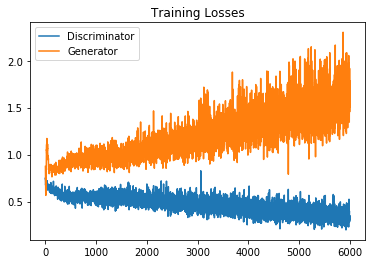

In [18]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

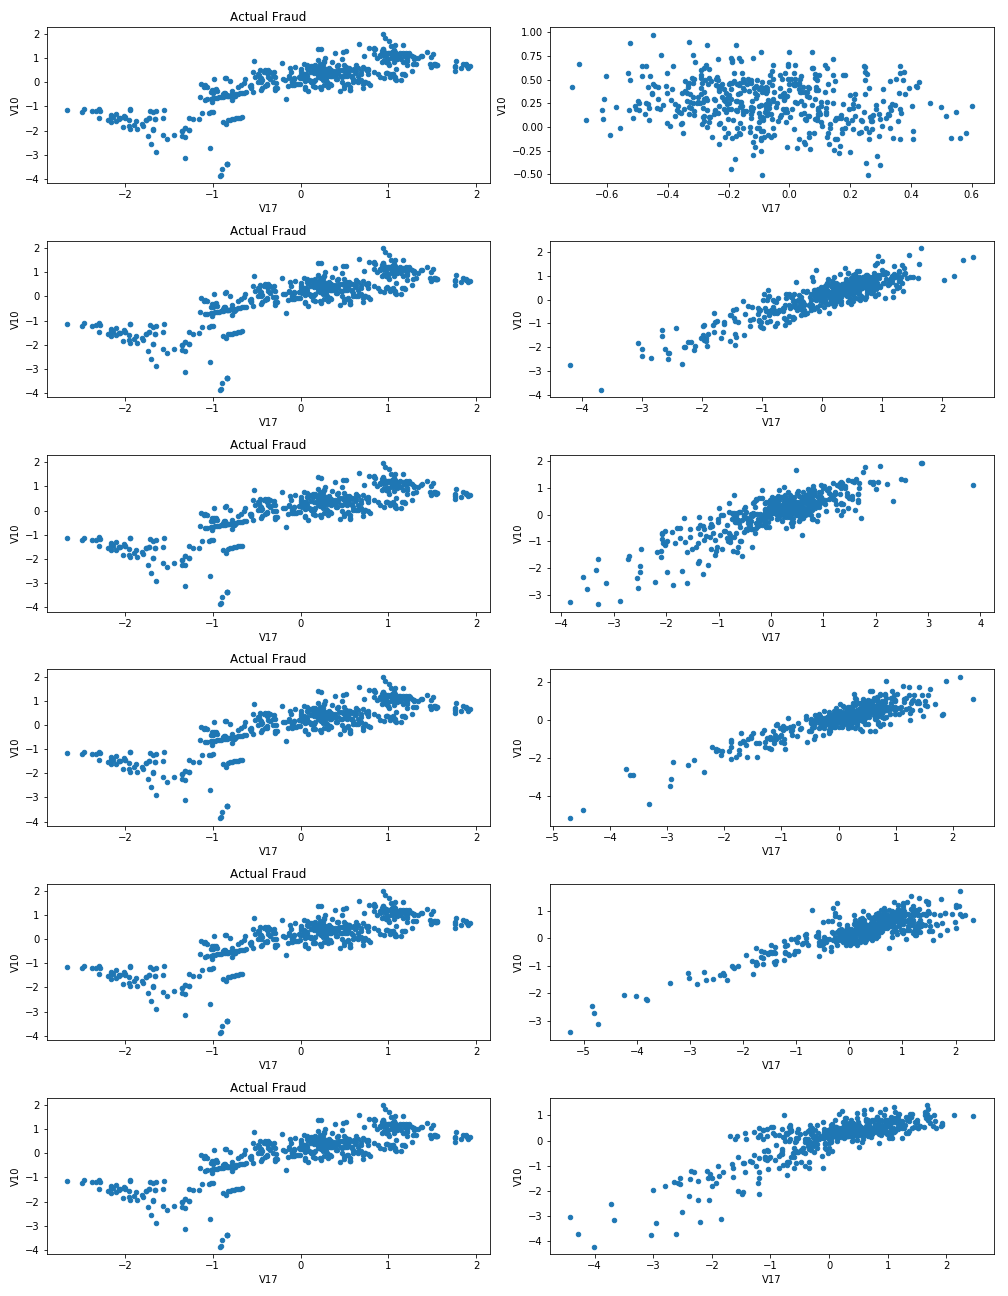

In [1]:
from IPython.display import Image
Image(filename='GANv1-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

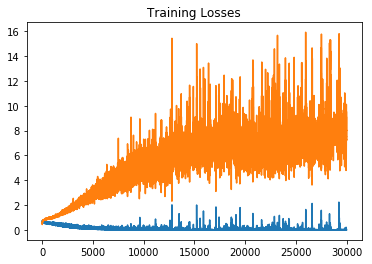

In [68]:
fig